In [1]:
import numpy as np
import os
import time
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten

from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
IMAGE_SIZE = 224

In [3]:
PATH = os.getcwd()

# Define data path
data_path ='C:/TensorFlow/vgg16/train'
data_dir_list = os.listdir(data_path)[:5] # 5 classes

img_data_list=[]

for dataset in sorted(data_dir_list):
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/'+ dataset + '/'+ img 
        img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        # print('Input image shape:', x.shape)
        img_data_list.append(x)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print (img_data.shape)

Loaded the images of dataset-Adult_leaf

Loaded the images of dataset-Child_leaf

Loaded the images of dataset-Defect_leaf

Loaded the images of dataset-Insect

Loaded the images of dataset-Perfect_leaf

(2600, 224, 224, 3)


In [4]:

# Define the number of classes
num_classes = 5
num_of_samples = (img_data.shape[0])
labels = np.ones((num_of_samples,), dtype='int64')

labels[0:325]=0
labels[325:1100]=1
labels[1100:1675]=2
labels[1675:1800]=3
labels[1800:]=4
	  
names = ['adult','child','defect','insect','perfect']


# convert class Labels to one-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

In [5]:
# Shuffle the dataset
x, y= shuffle(img_data, Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [6]:
image_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [8]:
model = ResNet50(weights='imagenet', include_top=False)
model.summary()

C:\Users\Hasibul Hasan\AppData\Local\conda\conda\envs\evn\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
last_layer = model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)

# Add fully connected & dropout layers
x = Dense(512, activation='relu', name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', name='fc-2')(x)
x = Dropout(0.5)(x)


In [10]:
# softmax layer for 5 classes
out = Dense(num_classes, activation='softmax', name='output_layer')(x)

custom_resnet_model2 = Model(model.input, outputs=out)
custom_resnet_model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
for layer in custom_resnet_model2.layers[:-10]:
    layer.trainable = False
    
custom_resnet_model2.layers[-1].trainable

True

In [12]:
custom_resnet_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
hist = custom_resnet_model2.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

Train on 2080 samples, validate on 520 samples
Epoch 1/20
2080/2080 [==============================] - 2906s 1s/step - loss: 1.0751 - acc: 0.6279 - val_loss: 2.1127 - val_acc: 0.2885
Epoch 2/20
2080/2080 [==============================] - 3218s 2s/step - loss: 0.4054 - acc: 0.8606 - val_loss: 2.6248 - val_acc: 0.2885
Epoch 3/20
2080/2080 [==============================] - 3174s 2s/step - loss: 0.2598 - acc: 0.9135 - val_loss: 3.3704 - val_acc: 0.2885
Epoch 4/20
2080/2080 [==============================] - 3141s 2s/step - loss: 0.1914 - acc: 0.9462 - val_loss: 1.9040 - val_acc: 0.2827
Epoch 5/20
2080/2080 [==============================] - 3127s 2s/step - loss: 0.1076 - acc: 0.9659 - val_loss: 2.1905 - val_acc: 0.2885
Epoch 6/20
2080/2080 [==============================] - 3112s 1s/step - loss: 0.1284 - acc: 0.9620 - val_loss: 2.3985 - val_acc: 0.2885
Epoch 7/20
2080/2080 [==============================] - 3059s 1s/step - loss: 0.1191 - acc: 0.9582 - val_loss: 2.7401 - val_acc: 0.1231
E

In [14]:
import matplotlib.pyplot as plt

In [15]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']
xc = range(20)

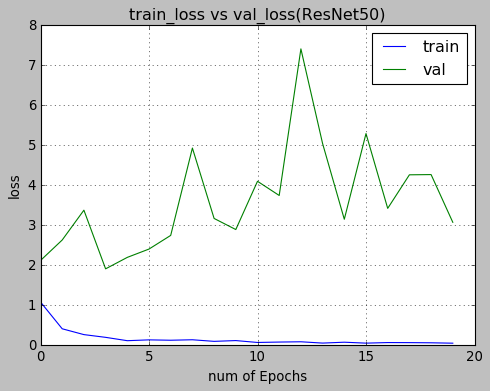

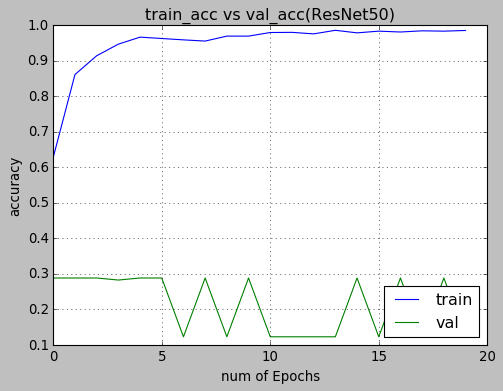

In [19]:
plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss(ResNet50)')
plt.grid(True)
plt.legend(['train', 'val'])
plt.style.use(['classic'])

plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc(ResNet50)')
plt.grid(True)
plt.legend(['train', 'val'], loc=4)
plt.style.use(['classic'])
plt.show()

Input image shape: (1, 224, 224, 3)
Image: 


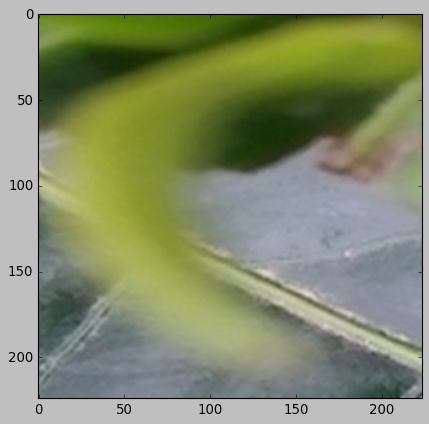


Prediction: 
adult: 	5.957826942903921e-06 %
child: 	99.5626449584961 %
defect: 	6.215674375198432e-05 %
insect: 	4.1807240336311224e-06 %
perfect: 	0.43728090822696686 %


In [33]:
img_path = 'C:/TensorFlow/vgg16/train/Child_leaf/Image1.jpg'
img = image.load_img(img_path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = custom_resnet_model2.predict(x)

print('Image: ')
plt.imshow(img)
plt.show()

print('\nPrediction: ')
preds = preds[0]
for i in range(len(preds)):
    print(names[i] + ': \t{} %'.format(preds[i]*100))

In [48]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools
%matplotlib inline
Y_pred = custom_resnet_model2.predict(X_test)
#print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)
#y_pred = model.predict_classes(X_test)
#print(y_pred)
target_names = ['class 0(adult)', 'class 1(child)', 'class 2(defect)','class 3(insect)', 'class 4(perfect)']

print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))


[[ 64   0   0   0   0]
 [150   0   0   0   0]
 [103   0   0   0   0]
 [ 20   0   0   0   0]
 [183   0   0   0   0]]


C:\Users\Hasibul Hasan\AppData\Local\conda\conda\envs\evn\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

  class 0(adult)       0.12      1.00      0.22        64
  class 1(child)       0.00      0.00      0.00       150
 class 2(defect)       0.00      0.00      0.00       103
 class 3(insect)       0.00      0.00      0.00        20
class 4(perfect)       0.00      0.00      0.00       183

       micro avg       0.12      0.12      0.12       520
       macro avg       0.02      0.20      0.04       520
    weighted avg       0.02      0.12      0.03       520



Confusion matrix, without normalization
[[ 64   0   0   0   0]
 [150   0   0   0   0]
 [103   0   0   0   0]
 [ 20   0   0   0   0]
 [183   0   0   0   0]]


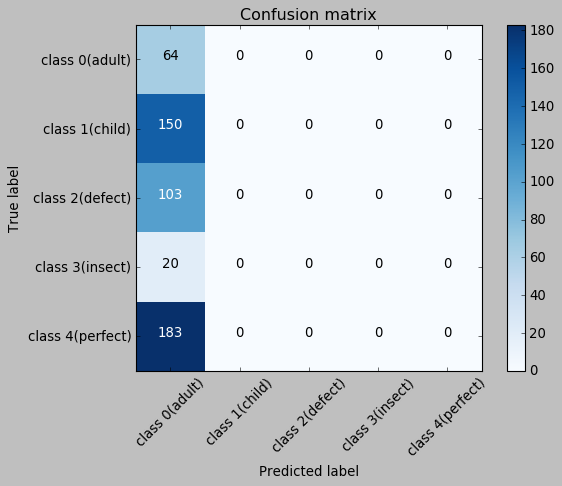

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))

np.set_printoptions(precision=2)

plt.figure()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
#plt.figure()
# Plot normalized confusion matrix
#plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
#                      title='Normalized confusion matrix')
#plt.figure()
plt.show()

In [35]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
model_json = custom_resnet_model2.to_json()
with open("model_Resnet50.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
custom_resnet_model2.save_weights("model_Resnet50.h5")
print("Saved model to disk")

# load json and create model
json_file = open('model_Resnet50.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_Resnet50.h5")
print("Loaded model from disk")

custom_resnet_model2.save('model_Resnet50.hdf5')
loaded_model=load_model('model_Resnet50.hdf5')


Saved model to disk
Loaded model from disk


In [44]:
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 64.92%
